In [109]:
from torch.optim.lr_scheduler import StepLR  # 变学习率
from torch.optim import lr_scheduler
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots 
import math

In [124]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1)
y = torch.sin(math.pi*x) + 0.2*torch.randn(x.size())  # y的形状与x一样


In [130]:
class custom(nn.Module):  # 激活函数含噪声参数
    def __init__(self,width):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1))  # 1个可学习参数 sigma
        #self.theta = nn.Parameter(torch.randn(1, width))
    def forward(self, input):
        temp = 1/(1+torch.exp(-input/self.sigma)) # 前向传播
        return temp

class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.custom1 = custom(n_hidden1)  # 自定义激活函数层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):

        x = self.hidden1(x)
        x = self.custom1(x)
        x = self.predict(x)  # 前向传播过程
        return x

In [131]:
# CPU!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!用这个！！！！！！！
# define the network，因为输入只有x，是一个1x1的向量，所以只有1个节点
net2 = Net(n_feature=1, n_hidden1=10, n_output=1)

device = torch.device('cpu')
#optimizer = torch.optim.SGD(net2.parameters(), lr=0.01)
optimizer = torch.optim.Adam(net2.parameters(), lr=0.01,betas=(0.96,0.96))
loss_func = torch.nn.MSELoss().to(device)  # 算loss，mse的loss
x = x.to(device)
y = y.to(device)

Text(0.5, 0, 'Loss = 0.0299')

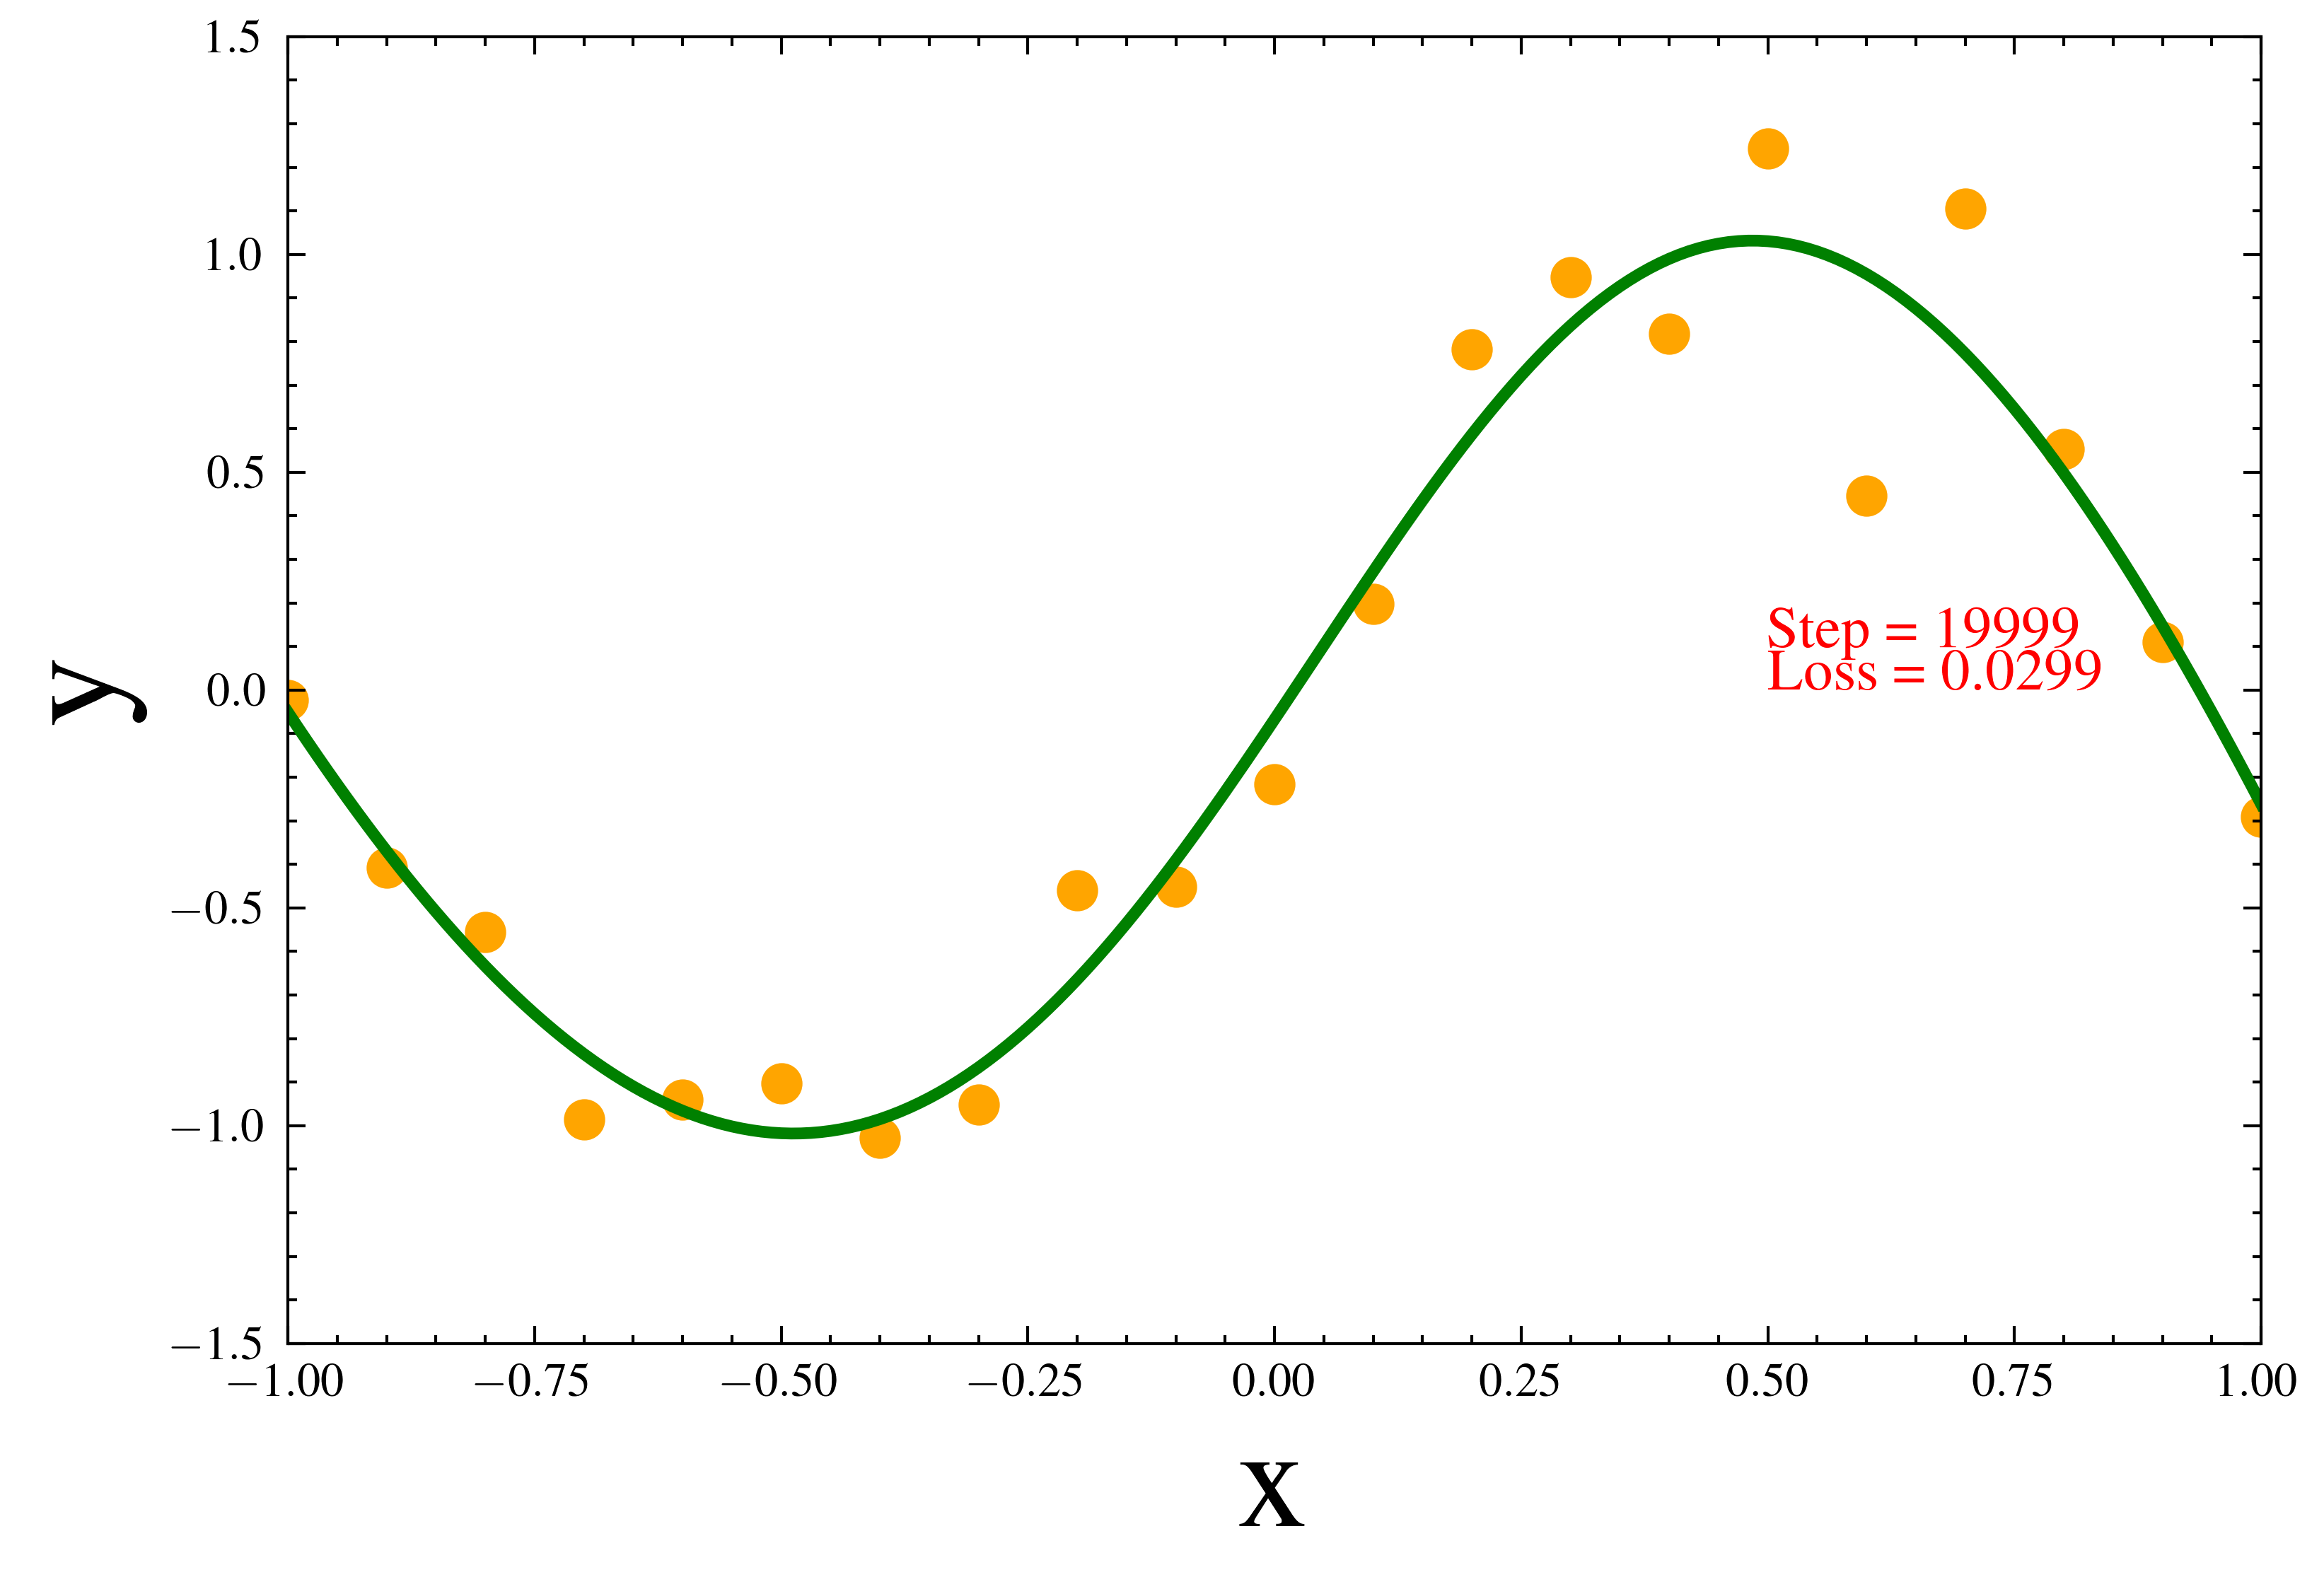

In [132]:
# CPU!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!用这个！！！
my_images = []
fig, ax = plt.subplots(figsize=(6, 4))  # 准备画图
plt.style.use(['science','ieee'])
epoch = 20000
para0 = torch.zeros(epoch)  # para0用来记录训练时每个epoch时的loss函数值
para1 = torch.zeros(epoch)  # para1记录验证时函数的loss
para2 = torch.zeros(epoch)  # para2记录学习率的变化
z=net2.custom1.sigma 
nn.init.constant_(z,16)

#scheduler = StepLR(optimizer, step_size=200, gamma=1)
for t in range(epoch):
   
    prediction2 = net2(x)  # 前向过程
    #loss = torch.nn.MSELoss(prediction, y).to(device)
    loss = loss_func(prediction2, y)     # 计算loss，通过prediction和y的差来计算mse

    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)         # 反向传播！
    optimizer.step()        # 更新参数！

    #para0[t] = loss.data
    para1[t] = net2.custom1.sigma.data

#    if(t) % 5 == 4:  # 每训练5个epoch就验证一次模型
#        testy = net(testx)  # 测试集前向传播，准确地说，这是验证过程
#        lossV = loss_func(testy, y)
#        para1[t] = lossV.data
        
#     para2[t] = optimizer.state_dict()['param_groups'][0]['lr']
#     scheduler.step()

# 画图和测试过程
# 在epoch循环之外画图，最后一个epoch训练完成之后的模型
plt.cla()
#ax.set_title(' sigmoid ', fontsize=35)
ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('y', fontsize=24)
ax.set_xlim(-1, 1)
ax.set_ylim(-1.5, 1.5)

# 前面几行别管了，到这里是画出训练集来，是橘色的散点。
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")

testx = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
testy = net2(testx)  # 测试集前向传播，准确地说，这是验证过程。

ax.plot(testx.data.numpy(), testy.data.numpy(), 'g-', lw=2)
ax.text(0.5, 0.1, 'Step = %d' % t, fontdict={'size': 10, 'color':  'red'})
# 画出验证集的拟合情况，是绿色的线
ax.text(0.5, 0, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 10, 'color':  'red'})

In [134]:
print(z)

Parameter containing:
tensor([4.5190], requires_grad=True)


In [44]:
class NetSigmoid(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(NetSigmoid, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        #self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        m=torch.nn.Sigmoid()
        x=m(x)
        x = self.predict(x)  # 前向传播过程
        return x

In [45]:
# CPU!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!用这个！！！！！！！
# define the network，因为输入只有x，是一个1x1的向量，所以只有1个节点
net = NetSigmoid(n_feature=1, n_hidden1=10, n_output=1)

device = torch.device('cpu')
#optimizer = torch.optim.SGD(net.parameters(), lr=0.01,momentum=0.96)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
loss_func = torch.nn.MSELoss().to(device)  # 算loss，mse的loss
x = x.to(device)
y = y.to(device)

Text(-1.45, 1.45, '(a)')

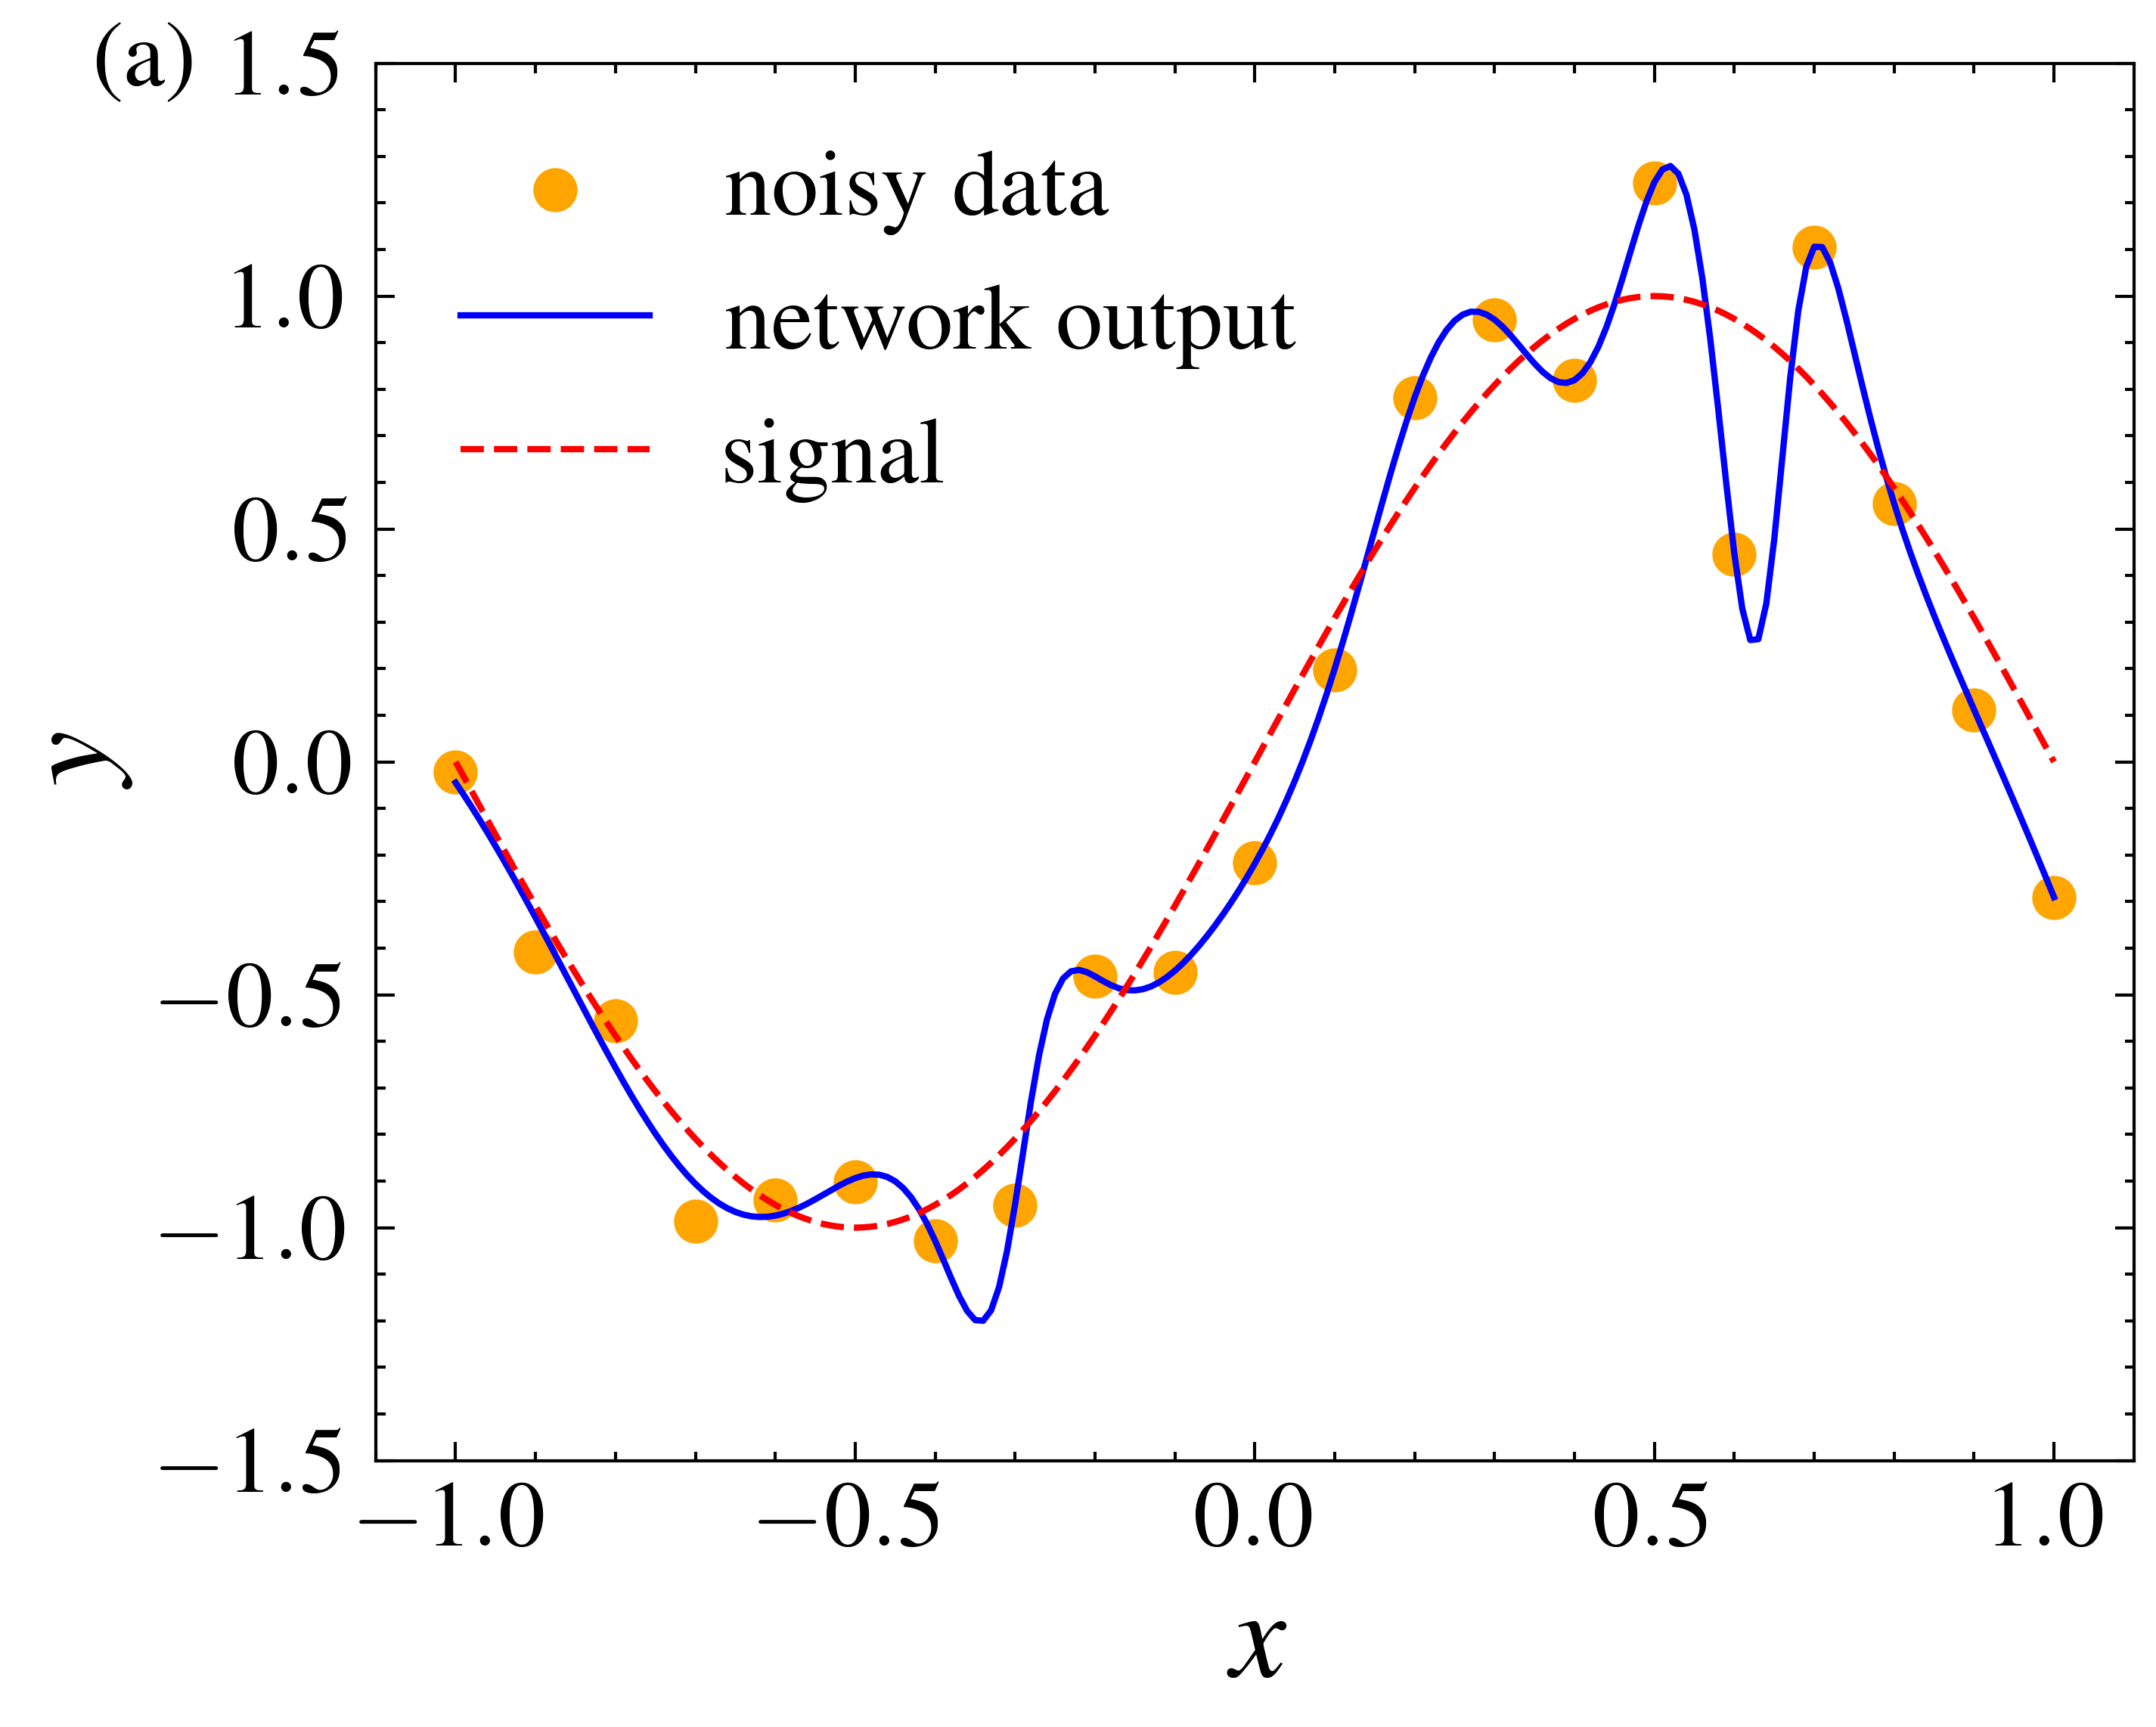

In [46]:
epoch = 20000
para0 = torch.zeros(epoch)  # para0用来记录训练时每个epoch时的loss函数值
para1 = torch.zeros(epoch)  # para1记录验证时函数的loss
para2 = torch.zeros(epoch)  # para2记录学习率的变化


#scheduler = StepLR(optimizer, step_size=200, gamma=1)
for t in range(epoch):
   
    prediction = net(x)  # 前向过程
    #loss = torch.nn.MSELoss(prediction, y).to(device)
    loss = loss_func(prediction, y)     # 计算loss，通过prediction和y的差来计算mse

    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)         # 反向传播！
    optimizer.step()        # 更新参数！

    para0[t] = loss.data

#    if(t) % 5 == 4:  # 每训练5个epoch就验证一次模型
#        testy = net(testx)  # 测试集前向传播，准确地说，这是验证过程
#        lossV = loss_func(testy, y)
#        para1[t] = lossV.data
        
#     para2[t] = optimizer.state_dict()['param_groups'][0]['lr']
#     scheduler.step()

# 画图和测试过程
# 在epoch循环之外画图，最后一个epoch训练完成之后的模型

fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$y$', fontsize=20)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange", label='noisy data',marker='o')
testx = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
testy = net(testx)  # 测试集前向传播
ax.plot(testx.data.numpy(), testy.data.numpy(), 'b-', lw=1,label='network output')
testx = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
signal = torch.sin(math.pi*testx)
ax.plot(testx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')
ax.legend(loc='upper left', fontsize=15)
ax.text(-1.45, 1.45, '(a)',fontdict={'size': 15, 'color':  'black'})

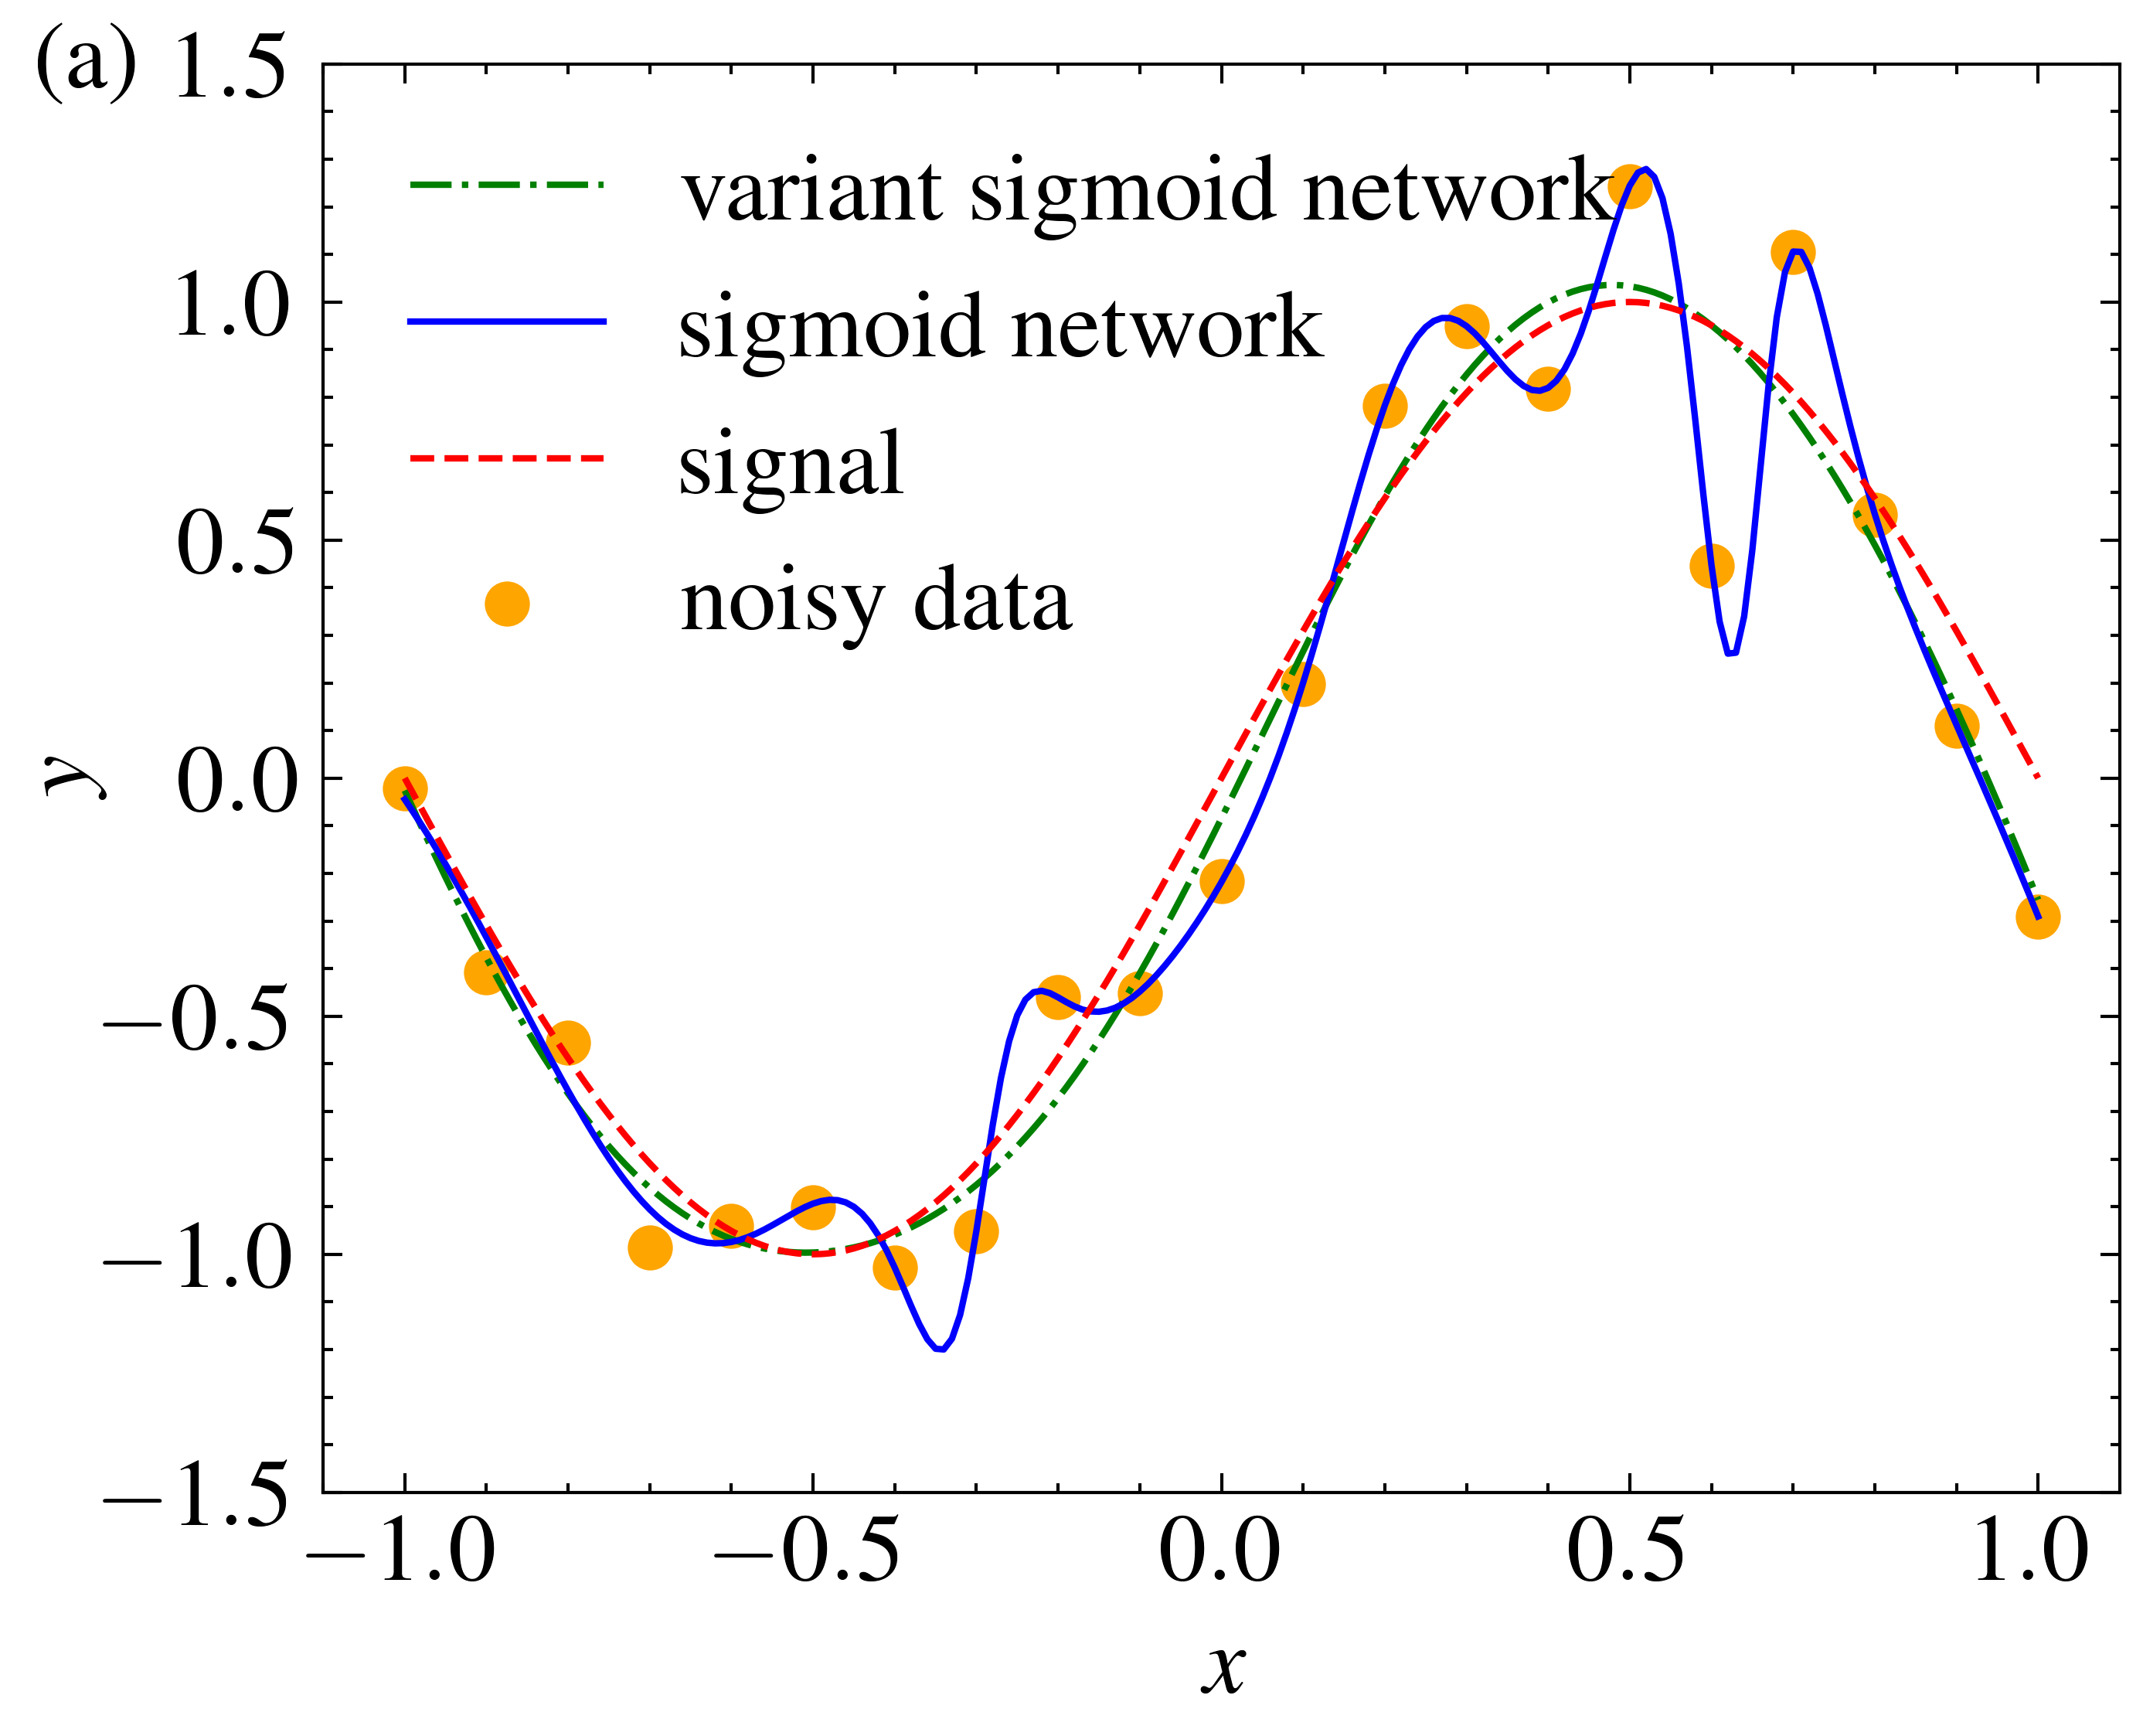

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from pylab import *
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15,labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
testx = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
testy2 = net2(testx)  # 测试集前向传播
ax.plot(testx.data.numpy(), testy2.data.numpy(), 'g-.', lw=1,label='variant sigmoid network')

testy = net(testx)  # 测试集前向传播
ax.plot(testx.data.numpy(), testy.data.numpy(), 'b-', lw=1,label='sigmoid network')
testx = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
signal = torch.sin(math.pi*testx)
ax.plot(testx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

ax.scatter(x.data.numpy(), y.data.numpy(), color="orange", label='noisy data',marker='o')
ax.legend(loc='upper left', fontsize=15)
ax.text(-1.45, 1.45, '(a)',fontdict={'size': 15, 'color':  'black'})

fig.savefig('D:/IEEE 2022 general AF/Figure3a.eps', dpi=800)

In [56]:
frame1 = pd.DataFrame(x.data.numpy()) #阈值网络训练loss
frame1.to_csv('D:/IEEE 2022 general AF/noisyx.csv', index=False)
frame1 = pd.DataFrame(y.data.numpy()) #阈值网络验证loss
frame1.to_csv('D:/IEEE 2022 general AF/noisyy.csv', index=False)

In [57]:
frame1 = pd.DataFrame(testx.data.numpy()) #阈值网络训练loss
frame1.to_csv('D:/IEEE 2022 general AF/testx.csv', index=False)
frame1 = pd.DataFrame(testy.data.numpy()) #阈值网络验证loss
frame1.to_csv('D:/IEEE 2022 general AF/testy.csv', index=False)

In [58]:
frame1 = pd.DataFrame(testy2.data.numpy()) #阈值网络验证loss
frame1.to_csv('D:/IEEE 2022 general AF/testy2.csv', index=False)

In [59]:
frame1 = pd.DataFrame(signal.data.numpy()) #阈值网络验证loss
frame1.to_csv('D:/IEEE 2022 general AF/signal.csv', index=False)

Text(18000, 3.5, '$ \\times 10^4$')

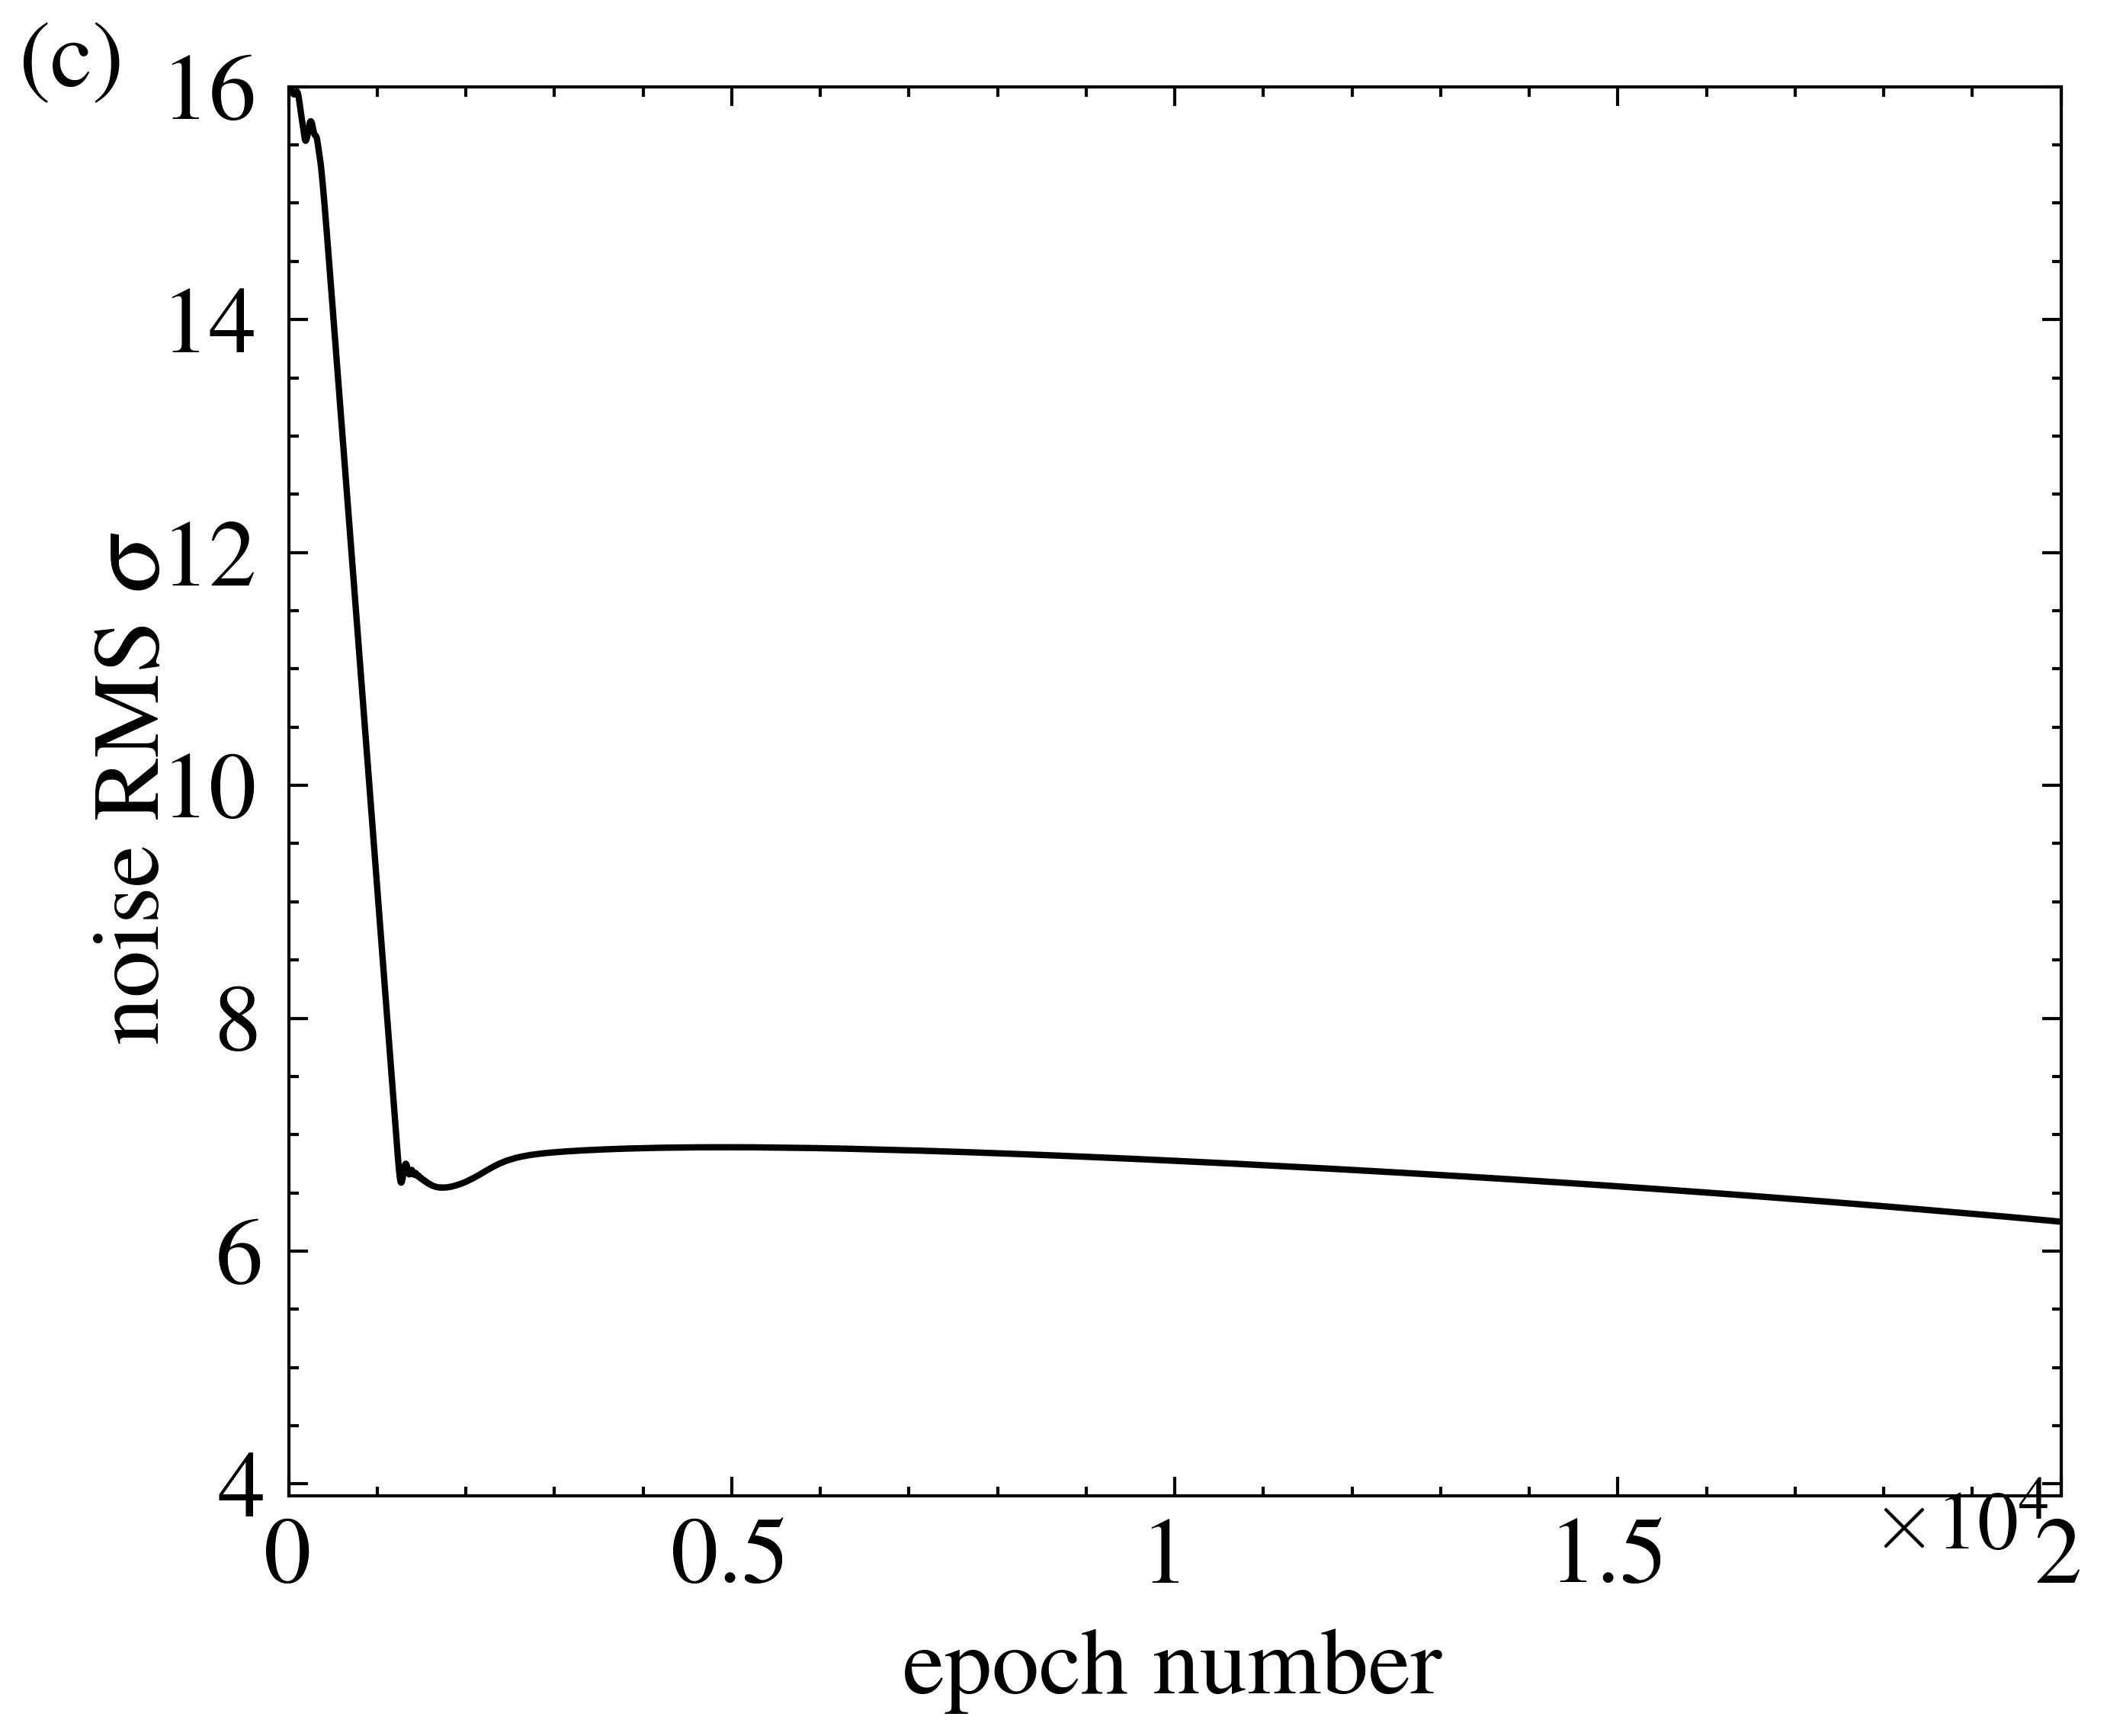

In [68]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('noise RMS $\sigma$', fontsize=15, labelpad = -1.2)
ax.set_xlim(-1, 20000)
ax.set_ylim(3.9, 16)
ax.plot(para1.data.numpy(), 'k-', lw=1)

ax.text(-3000, 16, '(c)',fontdict={'size': 15, 'color':  'black'})
plt.xticks([0,5000,10000,15000,20000],[0, 0.5, 1, 1.5, 2])
ax.text(18000, 3.5, r'$ \times 10^4$',fontdict={'size': 13, 'color':  'black'})
#fig.savefig('D:/IEEE 2022 general AF/fig3c.eps', dpi=800)

In [136]:
frame1 = pd.DataFrame(para1.data.numpy()) #阈值网络验证loss
frame1.to_csv('D:/IEEE 2022 general AF/noiseRMSvariantSigmoid.csv', index=False)

Text(18000, 3.5, '$ \\times 10^4$')

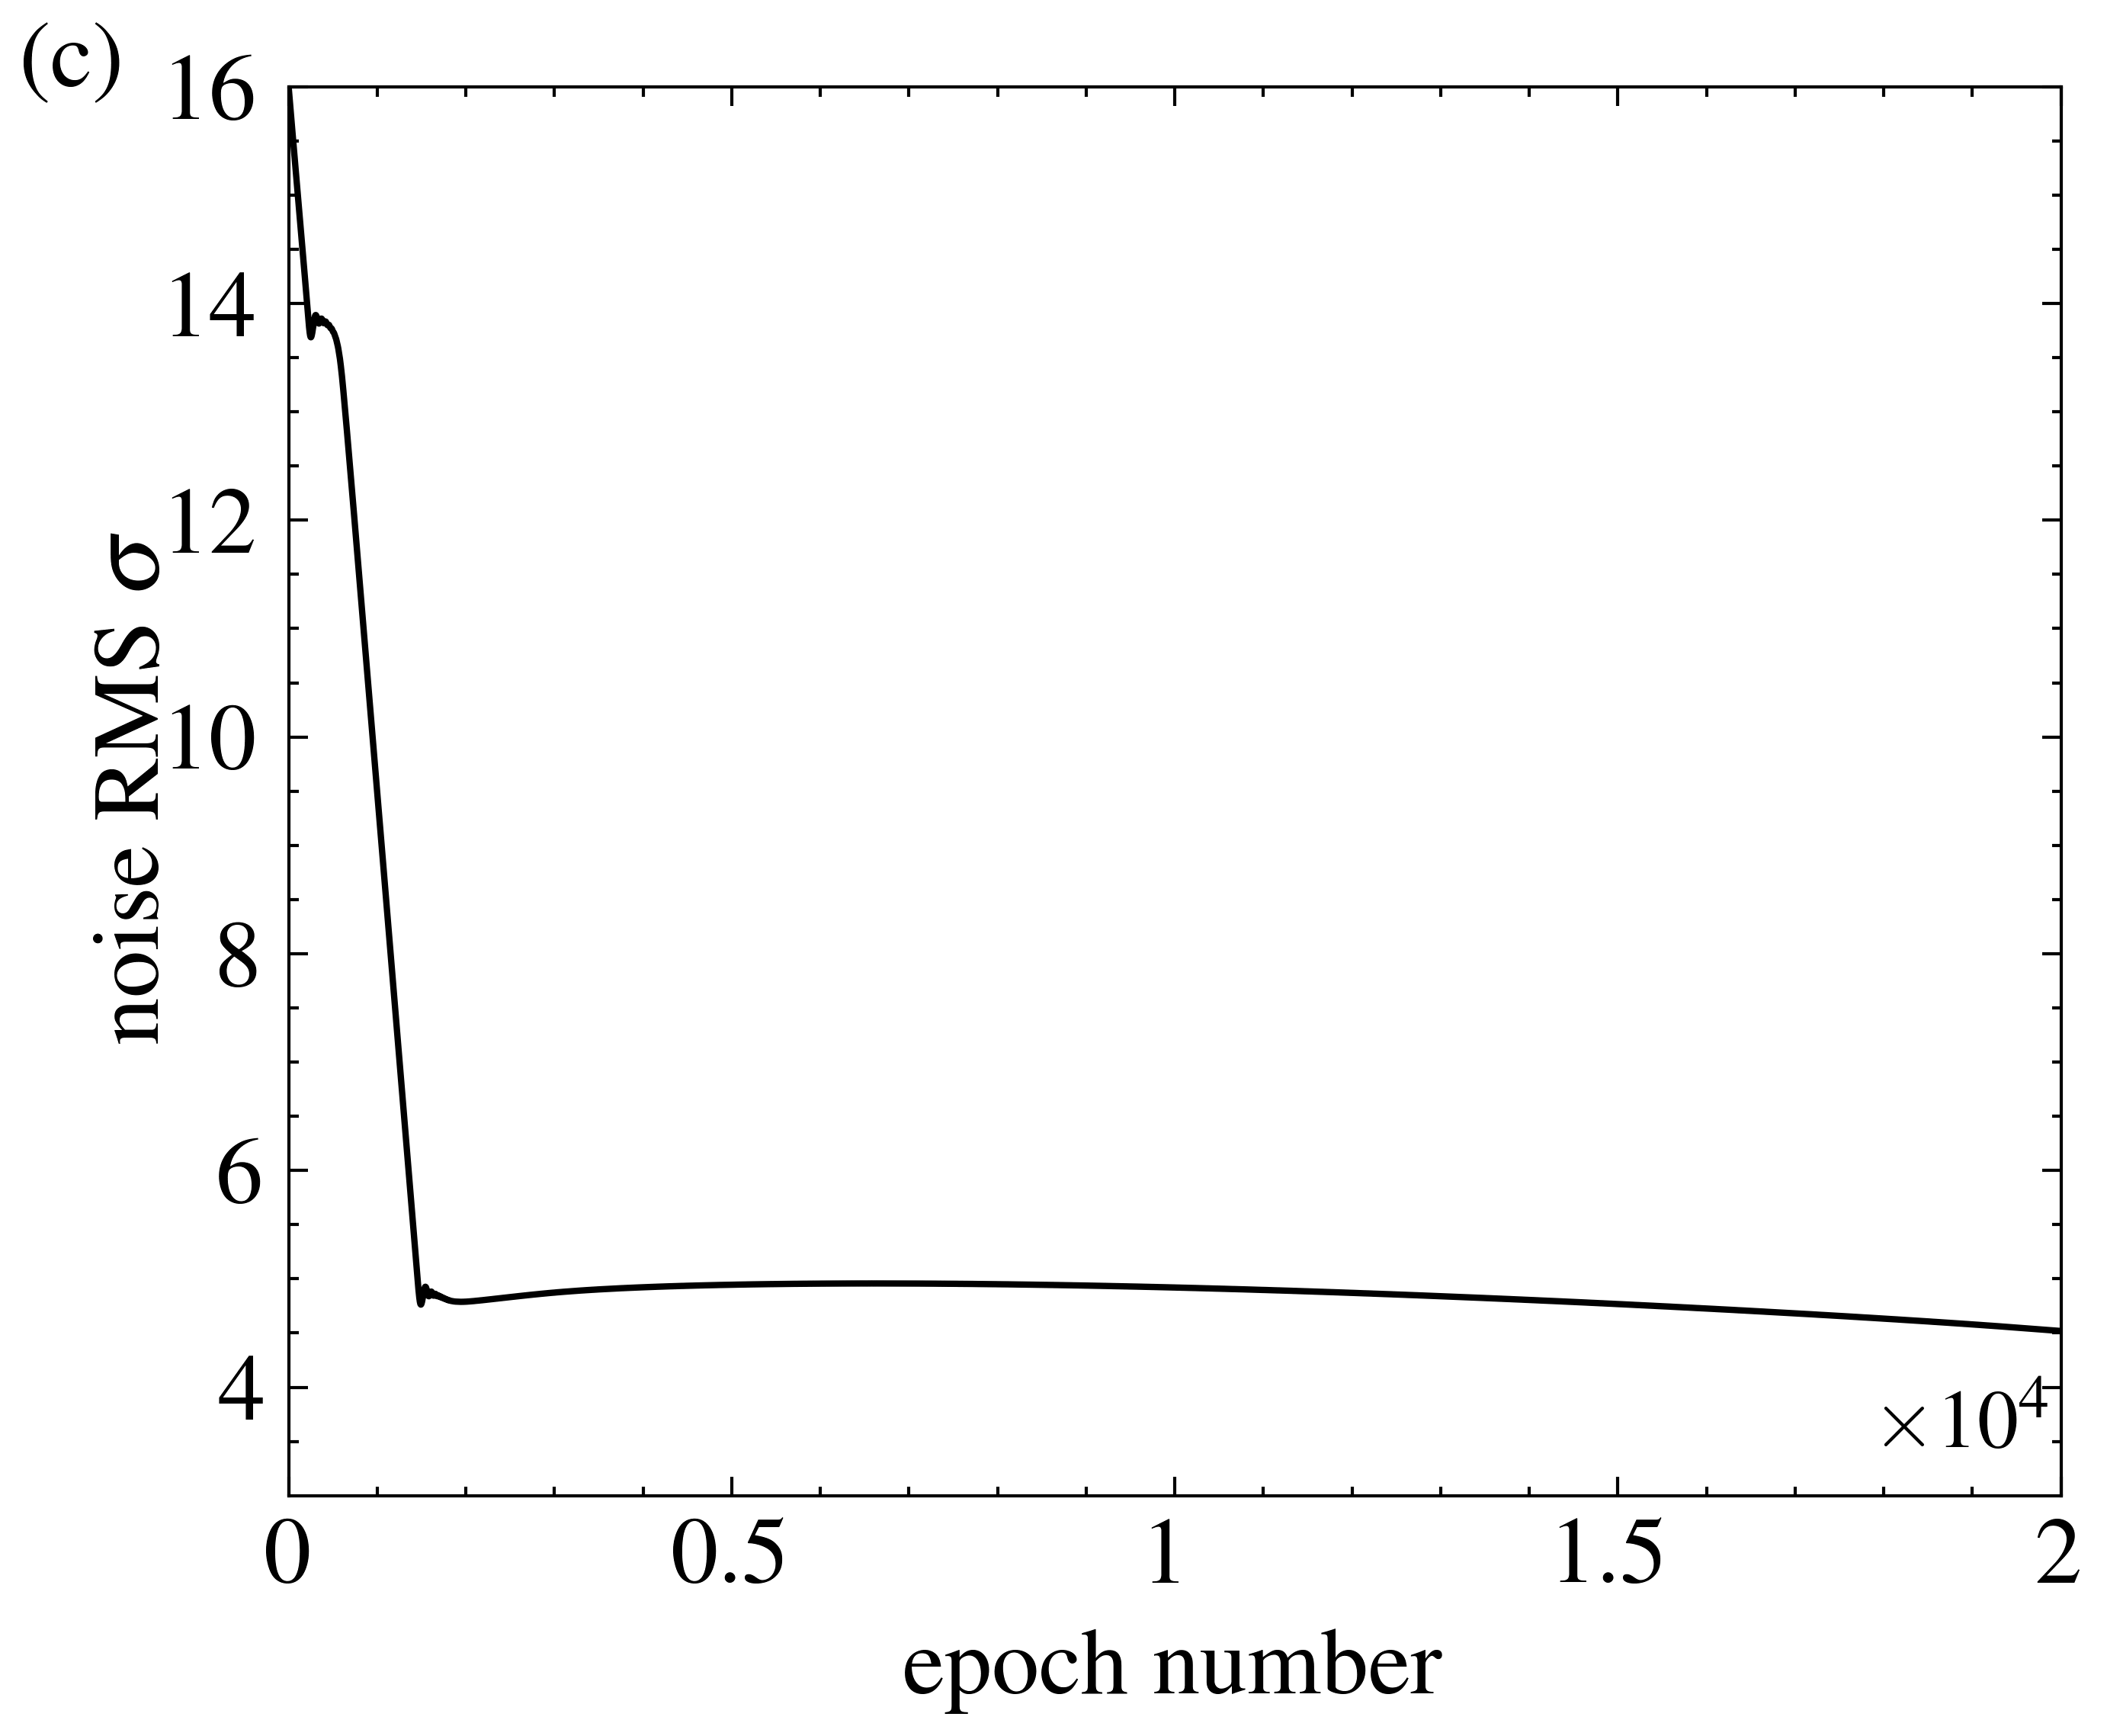

In [135]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('noise RMS $\sigma$', fontsize=15, labelpad = -1.2)
ax.set_xlim(-1, 20000)
ax.set_ylim(3, 16)
ax.plot(para1.data.numpy(), 'k-', lw=1)

ax.text(-3000, 16, '(c)',fontdict={'size': 15, 'color':  'black'})
plt.xticks([0,5000,10000,15000,20000],[0, 0.5, 1, 1.5, 2])
ax.text(18000, 3.5, r'$ \times 10^4$',fontdict={'size': 13, 'color':  'black'})
#fig.savefig('D:/IEEE 2022 general AF/fig3c.eps', dpi=800)